[Elo](https://elo.com.br/) is a Brazillian debit and credit card brand.  They offer credit and prepaid transactions, and have paired up with merchants in order offer promotions to cardholders.  In order to offer more relevant and personalized promotions, in a [recent Kaggle competition](https://www.kaggle.com/c/elo-merchant-category-recommendation), Elo challenged Kagglers to predict customer loyalty based on transaction history.  Presumably they plan to use a loyalty-predicting model in order to determine what promotions to offer to customers based on how certain offers are predicted to effect card owners' card loyalty.

In a [previous kernel](https://www.kaggle.com/brendanhasz/elo-data-cleaning-and-eda), we loaded and cleaned the data, and performed some exploratory data analysis.  In this kernel, we'll engineer new features about the card accounts, compute aggregate statistics about transactions made with each card, and then select which features to use in a predictive model.


**Outline**

- [Feature Engineering](#feature-engineering)
- [Feature Aggregations](#feature-aggregations)
- [Feature Selection](#feature-selection)
  - [Mutual Information](#mutual-information)
  - [Permutation-based Feature Importance](#permutation-based-feature-importance)
- [Conclusion](#conclusion)


Let's first load the packages we'll use:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from scipy.stats import spearmanr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

from catboost import CatBoostRegressor

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

!pip install git+http://github.com/brendanhasz/dsutils.git
from dsutils.encoding import one_hot_encode
from dsutils.encoding import TargetEncoderCV
from dsutils.printing import print_table
from dsutils.evaluation import permutation_importance_cv
from dsutils.evaluation import plot_permutation_importance

  Cloning http://github.com/brendanhasz/dsutils.git to /tmp/pip-req-build-vnpgu6a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-c3g3t2ba/wheels/a1/ff/2a/75bdc08e9c96d4917294db5e6faf99ef3de673f37992c52278
Successfully built dsutils
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Then we can load and clean the data.  (This was done in detail in the [previous kernel](https://www.kaggle.com/brendanhasz/elo-data-cleaning-and-eda) about data cleaning and EDA.)

In [2]:
# Cards data

# Datatypes for each column
# no nulls in test/train except for ONE ROW in test! (first_active_month)
dtypes = {
  'card_id':            'str',     # 201917 unique vals
  'target':             'float32', # -33.22 thru ~18
  'first_active_month': 'str',     # 2011-10 thru 2018-02
  'feature_1':          'uint8',   # 1 thru 5
  'feature_2':          'uint8',   # 1 thru 3
  'feature_3':          'uint8',   # 0 and 1
}
train = pd.read_csv('../input/train.csv',
                    usecols=dtypes.keys(),
                    dtype=dtypes)
del dtypes['target']
test = pd.read_csv('../input/test.csv',
                   usecols=dtypes.keys(),
                   dtype=dtypes)

# Add target col to test
test['target'] = np.nan

# Merge test and train
cards = pd.concat([train, test])

del train, test
gc.collect()

# Convert first_active_month to datetime
cards['first_active_month'] = pd.to_datetime(cards['first_active_month'],
                                             format='%Y-%m')

# Make card_id the index
cards.set_index('card_id', inplace=True)
gc.collect()
cards.sample(10)


# --------------------------------------------------

# Merchants data

# Datatypes of each column
# (don't load cols which are in transactions data, just use those vals)
# Nulls: NO nulls except for 13 rows in avg_sales_lag{3,6,12}
dtypes = {
  'merchant_id':                 'str',     # 334633 unique values
  'merchant_group_id':           'uint32',  # 1 thru 112586 (w/ some missing, ~109k uniques)
  'numerical_1':                 'float32', # ~ -0.06 thru ~ 183.8 (only 951 unique vals?)
  'numerical_2':                 'float32', # roughly the same as above
  'most_recent_sales_range':     'str',     # A, B, C, D, or E
  'most_recent_purchases_range': 'str',     # A, B, C, D, or E
  'avg_sales_lag3':              'float32', # most between 0 and 2, if you transform by 1/x, all but 3 are between 0 and 4
  'avg_purchases_lag3':          'float32', # most between 0 and 2, if you transform by 1/x, all but 3 are between 0 and 4
  'active_months_lag3':          'uint8',   # 1 to 3 
  'avg_sales_lag6':              'float32', # similar to avg_sales_lag3
  'avg_purchases_lag6':          'float32', # similar to avg_purchases_lag3
  'active_months_lag6':          'uint8',   # 1 to 6
  'avg_sales_lag12':             'float32', # similar to avg_sales_lag3
  'avg_purchases_lag12':         'float32', # similar to avg_purchases_lag3
  'active_months_lag12':         'uint8',   # 1 to 12
  'category_4':                  'str',     # Y or N
}

# Load the data
merchants = pd.read_csv('../input/merchants.csv',
                        usecols=dtypes.keys(),
                        dtype=dtypes)

# Map merchant_id to integer
merch_id_map = dict(zip(
    merchants['merchant_id'].values,
    merchants['merchant_id'].astype('category').cat.codes.values
))

def preprocess_merch_data(df):
    
    # Convert merchant ID to numbers
    df['merchant_id'] = df['merchant_id'].map(merch_id_map).astype('float32')

    # Inverse transforms
    inversions = [
        'avg_sales_lag3',
        'avg_sales_lag6',
        'avg_sales_lag12',
        'avg_purchases_lag3',
        'avg_purchases_lag6',
        'avg_purchases_lag12',
    ]
    for col in inversions:
        df[col] = 1.0/df[col]

    # Encode categorical columns
    bool_map = {'Y': 1, 'N': 0}
    five_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    conversions = [
        ('category_4', bool_map, 'uint8'),
        ('most_recent_sales_range', five_map, 'uint8'),
        ('most_recent_purchases_range', five_map, 'uint8')
    ]
    for col, mapper, new_type in conversions:
        df[col] = df[col].map(mapper).astype(new_type)
        
    # Clean up
    gc.collect()

# Preprocess the merchants data
preprocess_merch_data(merchants)


# ------------------------------------------------------

# Transactions data

# Datatypes of each column
# only NaNs are in category_3, merchant_id, and category_2
dtypes = {
    'authorized_flag':      'str',     # Y or N
    'card_id':              'str',     # 325540 unique values
    'city_id':              'int16',   # -1 then 1 to 347 (is -1 supposed to be nan?)
    'category_1':           'str',     # Y or N
    'installments':         'int8',    # -25, then -1 thru 12 (-1 supposed to be nan?)
    'category_3':           'str',     # A, B, C, and nan (ordinal?)
    'merchant_category_id': 'int16',   # 2 to 891
    'merchant_id':          'str',     # 334633 unique values and nans (164697 nans!)
    'month_lag':            'int8',    # -13 thru 0
    'purchase_amount':      'float32', # min: -0.746, med: -0.699, max: 11269.667
    'purchase_date':        'str',     # YYYY-MM-DD hh:mm:ss
    'category_2':           'float32', # 1 thru 5 and nan (ordinal?)
    'state_id':             'int8',    # -1 then 1 thru 24
    'subsector_id':         'int8'     # 1 thru 41
}

# Load the data
hist_trans = pd.read_csv('../input/historical_transactions.csv', 
                         usecols=dtypes.keys(),
                         dtype=dtypes)
new_trans = pd.read_csv('../input/new_merchant_transactions.csv', 
                        usecols=dtypes.keys(),
                        dtype=dtypes)

def preprocess_trans_data(df):
    
    # Convert merchant_id to numbers
    df['merchant_id'] = df['merchant_id'].map(merch_id_map).astype('float32')

    # Convert purchase_date to datetime
    df['purchase_date'] = df['purchase_date'].str.slice(0, 19)
    df['purchase_date'] = pd.to_datetime(df['purchase_date'],
                                         format='%Y-%m-%d %H:%M:%S')

    # Encode categorical columns
    bool_map = {'Y': 1, 'N': 0}
    three_map = {'A': 0, 'B': 1, 'C': 2}
    conversions = [
        ('authorized_flag', bool_map, 'uint8'),
        ('category_1', bool_map, 'uint8'),
        ('category_3', three_map, 'float32'), #has NaNs so have to use float
    ]
    for col, mapper, new_type in conversions:
        df[col] = df[col].map(mapper).astype(new_type)
        
    # Clean up
    gc.collect()

# Preprocess the transactions data
preprocess_trans_data(hist_trans)
preprocess_trans_data(new_trans)


<a id="feature-engineering"></a>
## Feature Engineering

At this point we have four tables:

* `hist_trans` - contains details about historical transactions
* `new_trans` - contains details about newer transactions
* `merchants` - contains information about the merchants
* `cards` - contains information about the card accounts

Eventually, we'll want one large table where each row corresponds to a card account, and each column corresponds to a feature of that account.  There's not a whole lot of information in the `cards` table as is, so we'll have to engineer features of each card using the information in the other three tables.  The idea is that information about how often an individual is making transactions, when, for how much, with what merchants,  with what *types* of merchants - and so on - will be informative as to how likely that individual is to have a high loyalty score.

Each transaction in `hist_trans` and `new_trans` has a `card_id`, which we can use to find all the transactions from a given card account in the `cards` dataset (there is also a `card_id` column in that table).  Similarly, each transaction also has a corresponding `merchant_id`, which we can use to look up the information about the corresponding merchant in the `merchants` dataset (that table also has a `merchant_id` column).

The first thing to do is merge the transactions datasets with the merchants dataset on the `merchant_id` column.  That is, for each transaction, we need to look up the information about the merchant which participated in that transaction in the merchants dataset, and append it to the transactions data.

The pandas merge function makes this pretty easy:

In [3]:
# Merge transactions with merchants data
hist_trans = pd.merge(hist_trans, merchants, on='merchant_id')
new_trans = pd.merge(new_trans, merchants, on='merchant_id')

# Clean up
del merchants
gc.collect()

49

Next, we'll want to encode some of the simpler categorical columns.  The `category_2` and `category_3` columns have only 5 and 3 unique values (and `NaN`s), so we'll simply one-hot encode them.

In [4]:
# One-hot encode category 2 and 3
cat_cols = ['category_2', 'category_3']
hist_trans = one_hot_encode(hist_trans,
                            cols=cat_cols)
new_trans = one_hot_encode(new_trans,
                           cols=cat_cols)
gc.collect()

182

Then, we can create some time-based features about the purchases.  For example: the hour of the day the purchase was made, the day of the week, the week of the year, the month, whether the purchase was made on a weekend, the time of the purchase relative to when the card owner was first active, etc.

In [5]:
# Time-based features for purchases
ref_date = np.datetime64('2017-09-01')
one_hour = np.timedelta64(1, 'h')
for df in [hist_trans, new_trans]:
    tpd = df['purchase_date']
    df['purchase_hour'] = tpd.dt.hour.astype('uint8')
    df['purchase_day'] = tpd.dt.dayofweek.astype('uint8')
    df['purchase_week'] = tpd.dt.weekofyear.astype('uint8')
    df['purchase_dayofyear'] = tpd.dt.dayofyear.astype('uint16')
    df['purchase_month'] = tpd.dt.month.astype('uint8')
    df['purchase_weekend'] = (df['purchase_day'] >=5 ).astype('uint8')
    df['purchase_time'] = ((tpd - ref_date) / one_hour).astype('float32')
    df['ref_date'] = ((tpd - pd.to_timedelta(df['month_lag'], 'M')
                          - ref_date ) / one_hour).astype('float32')

    # Time sime first active
    tsfa = pd.merge(df[['card_id']], 
                    cards[['first_active_month']].copy().reset_index(),
                    on='card_id', how='left')
    df['time_since_first_active'] = ((tpd - tsfa['first_active_month'])
                                     / one_hour).astype('float32')
    
    # Clean up
    del tsfa
    del df['purchase_date']
    gc.collect()

Finally, we need to convert the `first_active_month` column (a datetime) to a month.  This way at this point all of our data will be in a numerical format.

In [6]:
cards['first_active_month'] = (12*(cards['first_active_month'].dt.year-2011) + 
                               cards['first_active_month'].dt.month).astype('float32')

<a id="feature-aggregations"></a>
## Feature Aggregations

Now we can engineer features for each card account by applying aggregation functions on the transaction data corresponding to each card.  First, we need to group the transactions by the card account which was used to make them:

In [7]:
# Group transactions by card id
hist_trans = hist_trans.groupby('card_id', sort=False)
new_trans = new_trans.groupby('card_id', sort=False)

We'll also need to define some custom aggregation functions which will allow us to better extract information from the transactions.  The first is a function which computes the entropy given some categorical data.  A feature corresponding to entropy could be informative - for example, it could be that card accounts with high entropy over the merchants they use their card with are more likely to be more loyal card users than those who only use their card with a single merchant (and therefore have low entropy).

In [8]:
def entropy(series):
    """Categorical entropy"""
    probs = series.value_counts().values.astype('float32')
    probs = probs / np.sum(probs)
    probs[probs==0] = np.nan
    return -np.nansum(probs * np.log2(probs))

Another aggregation function which could be useful is one which computes the mean difference between *consecutive* items in a series.  For example, given a column with the purchase date, this function would compute the mean time between purchases.  This could conceivably be a good predictor of how likely an individual is to be a loyal card user: individuals who use their cards regularly and frequently are probably more likely to be loyal.

In [9]:
def mean_diff(series):
    """Mean difference between consecutive items in a series"""
    ss = series.sort_values()
    return (ss - ss.shift()).mean()

The period of a sequence of transactions could also be a useful feature.  That is, the difference between the minimum and maximum value.  For example, customers who have been making purchases over a long period of time (the difference between the date of their first and last purchases is large) may be more likely to be loyal card users.

In [10]:
def period(series):
    """Period of a series (max-min)"""
    return series.max() - series.min()

Finally, we'll create a function to compute the mode (just because pandas' default mode function doesn't handle `NaN`s well, or cases where there are two equally most common elements).

In [11]:
def mode(series):
    """Most common element in a series"""
    tmode = series.mode()
    if len(tmode) == 0:
        return np.nan
    else:
        return tmode[0]

Now we can actually compute the aggregations.  We'll define a list of aggregation functions to perform for each datatype:

In [12]:
# Aggregations to perform for each predictor type
binary_aggs = ['sum', 'mean', 'nunique']
categorical_aggs = ['nunique', entropy, mode]
continuous_aggs = ['min', 'max', 'sum', 'mean', 'std', 'skew', mean_diff, period]

And then, using those lists, we'll define a dictionary containing which aggregation functions to apply on which columns of the transactions data.  I've occasionally added a mean() aggregation function when it seems like the variable could be ordinal (but we're not sure because of the anonymous feature names!).

In [13]:
# Aggregations to perform on each column
aggs = {
    'authorized_flag':             binary_aggs,
    'city_id':                     categorical_aggs,
    'category_1':                  binary_aggs,
    'installments':                continuous_aggs,
    'category_3_nan':              ['mean'],
    'category_3_0.0':              ['mean'],
    'category_3_1.0':              ['mean'],
    'category_3_2.0':              ['mean'],
    'category_2_nan':              ['mean'],
    'category_2_1.0':              ['mean'],
    'category_2_2.0':              ['mean'],
    'category_2_3.0':              ['mean'],
    'category_2_4.0':              ['mean'],
    'category_2_5.0':              ['mean'],
    'merchant_category_id':        categorical_aggs,
    'merchant_id':                 categorical_aggs,
    'month_lag':                   continuous_aggs,
    'purchase_amount':             continuous_aggs,
    'purchase_time':               continuous_aggs + ['count'],
    'purchase_hour':               categorical_aggs + ['mean'],
    'purchase_day':                categorical_aggs + ['mean'],
    'purchase_week':               categorical_aggs + continuous_aggs,
    'purchase_month':              categorical_aggs + continuous_aggs,
    'purchase_weekend':            binary_aggs,
    'ref_date':                    continuous_aggs,
    'time_since_first_active':     continuous_aggs,
    'state_id':                    categorical_aggs,
    'subsector_id':                categorical_aggs,
    'merchant_group_id':           categorical_aggs,
    'numerical_1':                 continuous_aggs,
    'numerical_2':                 continuous_aggs,
    'most_recent_sales_range':     categorical_aggs + ['mean'], #ordinal?
    'most_recent_purchases_range': categorical_aggs + ['mean'], #orindal?
    'avg_sales_lag3':              continuous_aggs,
    'avg_purchases_lag3':          continuous_aggs,
    'active_months_lag3':          continuous_aggs,
    'avg_sales_lag6':              continuous_aggs,
    'avg_purchases_lag6':          continuous_aggs,
    'active_months_lag6':          continuous_aggs,
    'avg_sales_lag12':             continuous_aggs,
    'avg_purchases_lag12':         continuous_aggs,
    'active_months_lag12':         continuous_aggs,
    'category_4':                  binary_aggs,
}

Ok, phew, *now* we can actually compute the aggregations.  This'll take a while!

In [14]:
%%time

# Perform each aggregation
for col, funcs in aggs.items():
    for func in funcs:
        
        # Get name of aggregation function
        if isinstance(func, str):
            func_str = func
        else:
            func_str = func.__name__
            
        # Name for new column
        new_col = col + '_' + func_str
            
        # Compute this aggregation
        cards['hist_'+new_col] = hist_trans[col].agg(func).astype('float32')
        cards['new_'+new_col] = new_trans[col].agg(func).astype('float32')

CPU times: user 5h 29min 41s, sys: 1min 34s, total: 5h 31min 16s
Wall time: 5h 30min 35s


After blindly doing a bunch of aggregations on a dataset, it's usually a good idea to check for non-informative columns.  That is, columns which are all `NaN`, only contain one unique value, etc.  Let's check for those and remove them from the dataset.

In [15]:
def remove_noninformative(df):
    """Remove non-informative columns (all nan, or all same value)"""
    for col in df:
        if df[col].isnull().all():
            print('Removing '+col+' (all NaN)')
            del df[col]
        elif df[col].nunique()<2:
            print('Removing '+col+' (only 1 unique value)')
            del df[col]

remove_noninformative(cards)
gc.collect()

Removing new_authorized_flag_mean (only 1 unique value)
Removing new_authorized_flag_nunique (only 1 unique value)
Removing hist_category_3_nan_mean (only 1 unique value)
Removing new_category_3_nan_mean (only 1 unique value)
Removing hist_category_2_nan_mean (only 1 unique value)
Removing new_category_2_nan_mean (only 1 unique value)
Removing hist_active_months_lag3_max (only 1 unique value)
Removing hist_active_months_lag6_max (only 1 unique value)


4396

Now we have one, *giant* table, where each row corresponds to a card account for which we want to predict the loyalty, and each column corresponds to a feature of that account.  Unfortunately, what with all the aggregations we performed, we now have well over 400 features!

In [16]:
cards.info()

<class 'pandas.core.frame.DataFrame'>
Index: 325540 entries, C_ID_92a2005557 to C_ID_87e7979a5f
Columns: 427 entries, first_active_month to new_category_4_nunique
dtypes: float32(424), uint8(3)
memory usage: 530.0+ MB


Finally, we'll split the data into test and training data, as well as X and y data.

In [17]:
# Test data
test = cards['target'].isnull()
X_test = cards[test].copy()
del X_test['target']

# Training data
y_train = cards.loc[~test, 'target'].copy()
X_train = cards[~test].copy()
del X_train['target']

# Save file w/ all features
cards.reset_index(inplace=True)
cards.to_feather('card_features_all.feather')

# Clean up 
del cards
gc.collect()

14

<a id="feature-selection"></a>
## Feature Selection

See [this kernel](https://www.kaggle.com/brendanhasz/elo-feature-engineering-and-feature-selection-2) for the executed code for this section (running this entire kernel exceeds the Kaggle runtime limits, so I had to split it into two kernels).

Machine learning models don't generally perform well when they're given a huge number of features, many of which are not very informative.  The more superfluous features we give our model to train on, the more likely it is to overfit!  To prune out features which could confuse our predictive model, we'll perform some feature selection. 

Ideally, we'd fit our model a bunch of different times, using every possible different combination of features, and use the set of features which gives the best cross-validated results. But, there are a few problems with that approach.  First, that would lead to overfitting to the training data.  Second, and perhaps even more importantly, it would take forever.

There are a bunch of different ways to perform feature selection in a less exhaustive, but more expedient manner.  Forward selection, backward selection, selecting features based on their correlation with the target variable, and "embedded" methods such as Lasso regressions (where the model itself performs feature selection during training) are all options.  However, here we'll use two different methods: the mutual information between each feature and the target variable, and the permutation-based feature importance of each feature.

<a id="mutual-information"></a>
### Mutual Information

To get some idea of how well each feature corresponds to the target (the loyalty score), we can compute the [mutual information](https://en.wikipedia.org/wiki/Mutual_information) between each feature and the target. Let's make a function to compute the mutual information between two vectors.

In [18]:
def mutual_information(xi, yi, res=20):
    """Compute the mutual information between two vectors"""
    ix = ~(np.isnan(xi) | np.isinf(xi) | np.isnan(yi) | np.isinf(yi))
    x = xi[ix]
    y = yi[ix]
    N, xe, ye = np.histogram2d(x, y, res)
    Nx, _ = np.histogram(x, xe)
    Ny, _ = np.histogram(y, ye)
    N = N / len(x) #normalize
    Nx = Nx / len(x)
    Ny = Ny / len(y)
    Ni = np.outer(Nx, Ny)
    Ni[Ni == 0] = np.nan
    N[N == 0] = np.nan
    return np.nansum(N * np.log(N / Ni))

The mutual information represents the amount of information that can be gained about one variable by knowing the value of some other vairable.  Obviously this is very relevant to the task of feature selection: we want to choose features which knowing the value of will give us as much information as possible about the target variable.

Practically speaking, the nice thing about using mutual information instead of, say, the correlation coefficient, is that it is sensitive to nonlinear relationships.  We'll be using nonlinear predictive models (like gradient boosted decision trees), and so we don't want to limit the features we select to be only ones which have a linear relationship to the target variable.  Notice how the sin-like relationship in the middle plot below has a high mutual information, but not a great correlation coefficient.

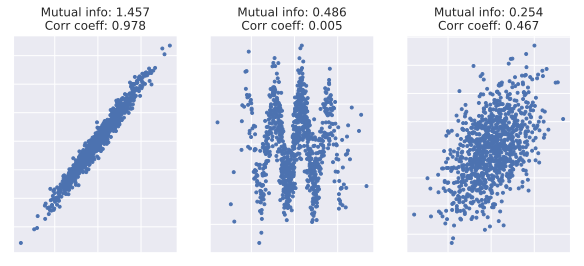

In [19]:
# Show mutual information vs correlation
x = 5*np.random.randn(1000)
y = [x + np.random.randn(1000),
     2*np.sin(x) + np.random.randn(1000),
     x + 10*np.random.randn(1000)]
plt.figure(figsize=(10, 4))
for i in range(3):    
    plt.subplot(1, 3, i+1)
    plt.plot(x, y[i], '.')
    rho, _ = spearmanr(x, y[i])
    plt.title('Mutual info: %0.3f\nCorr coeff: %0.3f'
              % (mutual_information(x, y[i]), rho))
    plt.gca().tick_params(labelbottom=False, labelleft=False)

We'll use the mutual information of the quantile-transformed aggregation scores (just so outliers don't mess up the mutual information calculation).  So, we'll need a function to perform the [quantile transform](https://en.wikipedia.org/wiki/Quantile_normalization), and one to compute the mutual information after applying the quantile transform:

In [20]:
def quantile_transform(v, res=101):
    """Quantile-transform a vector to lie between 0 and 1"""
    x = np.linspace(0, 100, res)
    prcs = np.nanpercentile(v, x)
    return np.interp(v, prcs, x/100.0)
    
    
def q_mut_info(x, y):
    """Mutual information between quantile-transformed vectors"""
    return mutual_information(quantile_transform(x),
                              quantile_transform(y))

Now we can compute the mutual information between each feature and the loyalty score.

In [21]:
"""
%%time

# Compute the mutual information
cols = []
mis = []
for col in X_train:
    mi = q_mut_info(X_train[col], y_train)
    cols.append(col)
    mis.append(mi)
    
# Print mut info of each feature
print_table(['Column', 'Mutual_Information'],
            [cols, mis])
"""

"\n%%time\n\n# Compute the mutual information\ncols = []\nmis = []\nfor col in X_train:\n    mi = q_mut_info(X_train[col], y_train)\n    cols.append(col)\n    mis.append(mi)\n    \n# Print mut info of each feature\nprint_table(['Column', 'Mutual_Information'],\n            [cols, mis])\n"

Let's only bother keeping the features with the top 200 mutual information scores.

In [22]:
"""
# Create DataFrame with scores
mi_df = pd.DataFrame()
mi_df['Column'] = cols
mi_df['mut_info'] = mis

# Sort by mutual information
mi_df = mi_df.sort_values('mut_info', ascending=False)
top200 = mi_df.iloc[:200,:]
top200 = top200['Column'].tolist()

# Keep only top 200 columns
X_train = X_train[top200]
X_test = X_test[top200]
"""

"\n# Create DataFrame with scores\nmi_df = pd.DataFrame()\nmi_df['Column'] = cols\nmi_df['mut_info'] = mis\n\n# Sort by mutual information\nmi_df = mi_df.sort_values('mut_info', ascending=False)\ntop200 = mi_df.iloc[:200,:]\ntop200 = top200['Column'].tolist()\n\n# Keep only top 200 columns\nX_train = X_train[top200]\nX_test = X_test[top200]\n"

<a id="permutation-based-feature-importance"></a>
### Permutation-based Feature Importance

A different way to select features is to try and train a model using *all* the features, and then determine how heavily the model's performance depends on the features.  But, we'll need to use a model which can handle a lot of features without overfitting too badly (i.e., an unregularized linear regression wouldn't be a good idea here).  So, we'll use a gradient boosted decision tree, specifically [CatBoost](http://catboost.ai/).  

Let's create a data processing and prediction pipeline.  First, we'll target encode the categorical columns (basically just set each category to the mean target value for samples having that category - see my [post on target encoding](https://brendanhasz.github.io/2019/03/04/target-encoding.html)).  Then, we can normalize the data and impute missing data (we'll just fill in missing data with the median of the column).  Finally, we can use CatBoost to predict the loyalty scores from the features we've engineered.

In [23]:
"""
# Regression pipeline
cat_cols = [c for c in X_train if 'mode' in c] 
reg_pipeline = Pipeline([
    ('target_encoder', TargetEncoderCV(cols=cat_cols)),
    ('scaler', RobustScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('regressor', CatBoostRegressor(verbose=False))
])
"""

"\n# Regression pipeline\ncat_cols = [c for c in X_train if 'mode' in c] \nreg_pipeline = Pipeline([\n    ('target_encoder', TargetEncoderCV(cols=cat_cols)),\n    ('scaler', RobustScaler()),\n    ('imputer', SimpleImputer(strategy='median')),\n    ('regressor', CatBoostRegressor(verbose=False))\n])\n"

We can measure how heavily the model depends on various features by using permutation-based feature importance.  Basically, we train the model on all the data, and then measure its error after shuffling each row.  When the model's error increases a lot after shuffling a row, that means that the feature which was shuffled was important for the model's predictions.

The advantage of permutation-based feature importance is that it gives a super-clear view and a single score as to how important each feature is.  The downside is that this score is intrinsically linked to the model.  Whereas computing the mutual information between the features and the target only depends on the data, permutation-based feature importance scores depend on the data, the model being used, and the interaction between the two.  If your model can't fit the data very well, your permutation scores will be garbage!

Luckily CatBoost nearly always does a pretty good job of prediction, even in the face of lots of features!  So, let's compute the permutation-based feature importance for each feature (the complete code is [on my GitHub](https://github.com/brendanhasz/dsutils/blob/master/src/dsutils/evaluation.py#L126)).

In [24]:
"""
%%time 

# Compute the cross-validated feature importance
imp_df = permutation_importance_cv(
    X_train, y_train, reg_pipeline, 'rmse', n_splits=2)
"""

"\n%%time \n\n# Compute the cross-validated feature importance\nimp_df = permutation_importance_cv(\n    X_train, y_train, reg_pipeline, 'rmse', n_splits=2)\n"

Then, we can plot the importance scores for each feature.  These scores are just the difference between the model's error with no shuffled features and the error with the feature of interest shuffled.  So, larger scores correspond to features which the model needs to have a low error.

In [25]:
"""
# Plot the feature importances
plt.figure(figsize=(8, 100))
plot_permutation_importance(imp_df)
plt.show()
"""

'\n# Plot the feature importances\nplt.figure(figsize=(8, 100))\nplot_permutation_importance(imp_df)\nplt.show()\n'

Finally, we'll want to save the features so that we can use them to train a model to predict the loyalty scores.  Let's save the top 100 most important features to a [feather](https://github.com/wesm/feather) file, so that we can quickly load them back in when we do the modeling.  First though, we need to figure out which features *are* the ones with the best importance scores.

In [26]:
"""
# Get top 100 most important features
df = pd.melt(imp_df, var_name='Feature', value_name='Importance')
dfg = (df.groupby(['Feature'])['Importance']
       .aggregate(np.mean)
       .reset_index()
       .sort_values('Importance', ascending=False))
top100 = dfg['Feature'][:100].tolist()
"""

"\n# Get top 100 most important features\ndf = pd.melt(imp_df, var_name='Feature', value_name='Importance')\ndfg = (df.groupby(['Feature'])['Importance']\n       .aggregate(np.mean)\n       .reset_index()\n       .sort_values('Importance', ascending=False))\ntop100 = dfg['Feature'][:100].tolist()\n"

Then, we can save those features (and the corresponding target variable!) to a feather file.

In [27]:
"""
# Save file w/ 100 most important features
cards = pd.concat([X_train[top100], X_test[top100]])
cards['target'] = y_train
cards.reset_index(inplace=True)
cards.to_feather('card_features_top100.feather')
"""

"\n# Save file w/ 100 most important features\ncards = pd.concat([X_train[top100], X_test[top100]])\ncards['target'] = y_train\ncards.reset_index(inplace=True)\ncards.to_feather('card_features_top100.feather')\n"

<a id="conclusion"></a>
## Conclusion

Now that we've engineered features for each card account, the next thing to do is create models to predict the target value from those features.  In [the next kernel](https://www.kaggle.com/brendanhasz/elo-modeling), we'll try different modeling techniques to see which gives the best predictions.